In [ ]:
import pandas as pd
import numpy  as np
import datetime
import time

from matplotlib import pyplot as plt

from jax import numpy as jnp
from jax import grad, jit, vmap, value_and_grad
from jax import lax as jlax

import optax

import sys
sys.path.append("/home/pushkar/modeling/my_python_project/lib/")
from ts import tsdata_utils as tu
from ts import research_utils as ru
from ts import ms_utils as mu
from utils import pandas_utils as pdu


def get_exponentially_decaying_weights(n_steps, half_life_frac):
    """
        Description
        -----------
        Self explanatory.
    
        Arguments
        ---------
        n_steps:
            Number of weights to returns
            
        half_life_frac:
            Used to compute the half life of the exponentially decaying weights.
            half life = n_steps * half_life_frac
        
        
        Returns
        -------
        A numpy array of shape (n_steps, ) containing the weights such that the last element
        is the largest weight (to be applied to the most recent observation) and the first element
        is the smallest weight (to be applied to the oldest observation).        
        
        Notes
        -----
        1) All weights sum to 1.
        
    """
    
    assert(half_life_frac < 1)
    
    hl = int(n_steps * half_life_frac)
    assert(hl > 1)
    lam = np.exp(-np.log(2.0) / (hl-1))
    weights = np.flip(np.power(lam, np.arange(n_steps)))
    weights /= np.sum(weights)
    
    return weights

def get_trapezoidal_weights(n_steps, rampup_frac, rampup_start=0.2):
    """
        Description
        -----------
        Self explanatory.
    
        Arguments
        ---------
        n_steps:
            Number of weights to returns
            
        rampup_frac:
            Used to compute the duration over which the weights rampup from "rampup_start" (eg. 0) to 1.0
            ramp length = n_steps * rampup_frac
            
        rampup_start:
            The value to use at the start of the rampup, going all the way to 1.0
        
        
        Returns
        -------
        A numpy array of shape (n_steps, ) containing the weights such that the last element
        is weight to be applied to the most recent observation, and the first element
        is the weight to be applied to the oldest observation.
        
        Notes
        -----
        1) All weights sum to 1.
        
    """
    
    assert(rampup_start <= 1.0 and rampup_start >= 0.0)
    assert(rampup_frac < 1.0)
    
    ramp_len = int(n_steps * rampup_frac)
    ramp_slope = (rampup_start - 1.0) / ramp_len
    line_func = lambda _x: ramp_slope * _x + rampup_start
    weights = np.hstack([ line_func(-1*np.arange(ramp_len)) , line_func(-ramp_len) * np.ones(n_steps - ramp_len) ])
    weights = np.flip(weights)
    weights /= np.sum(weights)
    
    return weights

def get_half_rectangle_weights(n_steps, zeroweight_frac):
    
    assert(zeroweight_frac >= 0.0 and zeroweight_frac < 1.0)
    
    zeroweight_len = int(n_steps * zeroweight_frac)
    weights = np.hstack([ np.zeros(zeroweight_len), np.ones(n_steps - zeroweight_len) ])
    weights = np.flip(weights)
    weights /= np.sum(weights)
    
    return weights

In [ ]:
univ = "FUTSTK.most_liquid"
#univ = "EQ"

if True:
    start_date = "20180101"
    end_date   = "20181231"
    df_train = mu.get_modelstate_panel(univ, start_date, end_date)

    start_date = "20180703"
    end_date   = "20180725"
    df_test = mu.get_modelstate_panel(univ, start_date, end_date)
else:
    start_date = "20160103"
    end_date   = "20201231"
    df_train = mu.get_modelstate_panel(univ, start_date, end_date)
    
    univ_uri = "/home/pushkar/modeling/tsdata/nse/universes/fo/FUTSTK.most_liquid.trading"
    df_univ = tu.read_table(univ_uri, start_date, end_date)
    df_train = tu.left_join(df_univ, df_train, keys=['SYMBOL'], strict_lookback=False)
    
    

In [ ]:
ret_type = 'open2open_lagging_1dret'
#ret_type = 'intraday_ret'

vol_type = 'open2open_lagging_1dret_robust_1dvol'
#vol_type = 'intraday_ret_robust_1dvol'



df = df_train[['SYMBOL', ret_type, vol_type]]
dfr = df.reset_index().pivot(index='timestamp', columns='SYMBOL', values=ret_type)
R  = np.nan_to_num(dfr.to_numpy(), 0.0)

dfv = df.reset_index().pivot(index='timestamp', columns='SYMBOL', values=vol_type)
V = np.nan_to_num(dfv.to_numpy(), 0.0)

R = R / V
R  = np.nan_to_num(R, 0.0)

## drop all columns with large % of zero entries.
pct_non_zeros = 0.8
R = R[:, (np.count_nonzero(R, axis=0) / R.shape[0]) > pct_non_zeros]
R.shape

In [ ]:
"""
    *Sanity Check*
    --------------
    As a sanity check, we use a random data matrix to see whether the trading strategy 
    learnes anything that applies to instruments over which it was NOT trained (using the
    same in-sample training time period).
"""
R = np.random.normal(0, 1, R.shape)

## No-Kernel Time series feature engineering

In [264]:
_del = 1e-3
_c = 0.01

f1 = jit(lambda z: 1 / (1+jlax.exp(-5*(z-1))))
f2 = jit(lambda z: 1 -1 / (1+jlax.exp(-5*(z+1))))
f12 = jit(lambda z: (z**2)*(f1(z)+f2(z)) )

@jit
def l2_norm(v):
    return jnp.sqrt(jnp.dot(v, v))

@jit
def angle(v1, v2):
    return jnp.dot(v1, v2) / (l2_norm(v1) * l2_norm(v2))

@jit
def zero_mean_constraint(v):
    arg = jnp.sum(v)
    arg /= _del
    return _c*f12(arg)
    
@jit
def orthogonality_constraint(v1, v2):
    arg = angle(v1, v2)
    arg /= _del
    return _c * f12(arg)

@jit
def acf_constraint(acf_val : np.ndarray, acf_th : float):
    _b = 100
    return jlax.exp(-1*(acf_val - acf_th)) * (1. / (1+jlax.exp(_b*(acf_val-acf_th))))


@jit
def unit_norm_constraint(v):
    arg = jnp.dot(v, v) - 1
    arg /= _del
    return _c * f12(arg)

@jit
def project(v_to_project, v_to_project_on):
    return jnp.dot(v_to_project, v_to_project_on) / jnp.dot(v_to_project_on, v_to_project_on)

@jit
def rowwise_csz(M):
    ## cross-sectionally z-score
    mean = jnp.mean(M, axis=1)
    sd = jnp.std(M, axis=1)
    return (M - mean[:, None]) / sd[:, None]


def initialize_params(feature_lb, n_factors):
    init_params = dict(zip(["beta_%s" % str(i) for i in range(1, n_factors+1)]\
                               +["gamma_%s" % str(i) for i in range(1, n_factors+1)]\
                               ,\
                             [None for i in range(1, n_factors+1)]\
                               +[0.5 for i in range(1, n_factors+1)]\
                          ))
    
    for i in range(1, n_factors+1):
        b = np.random.normal(0, 1, feature_lb)
        if i == 1:
            init_params["beta_"+str(i)] = b
        else:
            projections = [project(b, init_params["beta_"+str(j)]) for j in range(1, i)]
            for j in range(1, i):
                b -= projections[j-1]*init_params["beta_"+str(j)]
            init_params["beta_"+str(i)] = b
            

    return init_params

#@jit
def get_projection_matrix(N, n_size, arr=None):
    P = jnp.eye(N, N)
    if arr is None:
        arr = np.ones(n_size)
    for _k in range(n_size):
        P += jnp.eye(N, N, k=_k+1)*arr[_k]
        P += jnp.eye(N, N, k=-(_k+1))*arr[_k]
    P /= (2*n_size+1)
    return P

@jit
def smooth(v : jnp.ndarray, P : jnp.ndarray):
    return jnp.dot(P, v)

def get_pred_resp(params, R, flb):
    """
        R   -> TxN matrix (T: timestamps, N:number of instruments)
               T > flb
        flb -> feature definition lookback
    """
    
    #assert(R.shape[0] > flb)
    
    n_ts = R.shape[0]
    n_inst = R.shape[1]
    
    ## n new feature definitions to learn.
    n_factors = len([_k for _k in params.keys() if _k.startswith("beta_")])
    
    R_rolling = np.lib.stride_tricks.sliding_window_view(R, window_shape=flb, axis=0).transpose(0, 2, 1)
    
    """PARAMETER"""
    leading_steps = 2 ## how many steps into the future are we predicting?
    assert(leading_steps>=1)
    
    R_train = R_rolling[:-leading_steps, :, :]
    R_target = R_rolling[leading_steps:, -1, :]
    
    ## just a good sanity check to proper construction of 
    ## training data and target variable data.
    if leading_steps == 1:
        assert(np.allclose(R_train[1:,-1,:], R_target[:-1,:]))
    
    
    if False:
        P5 = get_projection_matrix(N=flb, n_size=5)
        """
            smoothing the raw returns this way results in faster convergence of the
            optimization step. there is a minimal degradation in the performance of the learnt trading strategy.
        """
        A = (vmap(lambda X: jnp.dot(P5, X), in_axes=0)) (R_train)
        R_train = A
    
    if False:
        W = np.diag(get_exponentially_decaying_weights(n_steps=flb, half_life_frac=0.8))
        A = (vmap(lambda X: jnp.dot(W, X), in_axes=0)) (R_train)
        R_train = A
    
    
    block_fcst = jnp.full_like(R_target, 0.0)
    for f_idx in range(1, n_factors+1):
        beta = params["beta_"+str(f_idx)]    
        gamma = params["gamma_"+str(f_idx)]
        f_idx_fcst = (vmap(lambda X: jnp.dot(beta, X), in_axes=0)) (R_train)
        f_idx_fcst *= gamma
        #assert( f_idx_fcst.shape[1] == n_inst )
        block_fcst += f_idx_fcst
        
        
    if True:
        _f = lambda x: jlax.cond(jlax.abs(x) < 5, lambda _x: _x, lambda _x: jlax.sign(_x)*5, x)
        block_fcst = vmap(lambda v: vmap(_f, in_axes=0)(v), in_axes=0)(block_fcst)
        
    return block_fcst, R_target

@jit
def ac1(_pred_matrix : jnp.ndarray):
    return jnp.mean(vmap(lambda i: angle(_pred_matrix[i,:], _pred_matrix[i+1,:]))(np.arange(_pred_matrix.shape[0]-1)))

def objective(params, R, flb):
    """ 
        R   -> TxN matrix (T: timestamps, N:number of instruments)
               T > flb
        flb -> feature definition lookback
    """
    
    #assert(R.shape[0] > flb)
        
    ## n new feature definitions to learn.
    n_factors = len([_k for _k in params.keys() if _k.startswith("beta_")])
    
    block_fcst, R_target = get_pred_resp(params, R, flb)
    
    ## normalize each row - 
    foo = vmap(lambda v: l2_norm(v), in_axes=0)

    n = foo(R_target)
    R_target /= n[:, None]

    n = foo(block_fcst)
    block_fcst /= n[:, None]

    X = R_target * block_fcst
    W = np.eye(X.shape[0])
    mult = X.shape[0]
    if False:
        W = np.diag(get_exponentially_decaying_weights(n_steps=X.shape[0], half_life_frac=0.2))
        W *= mult
    
    obj = jnp.mean(jnp.dot(W, jnp.sum(X, axis=1)))

    
    """
        *TODO* - Need to work on expressing the orthogonality constraints for the optimization problem.
        
               - Actually: calibrating the parameters of the penalty term, namely: _c and _del, made the optimization problem work!
                           now, the penalty terms do not "blow up out of proportion" whenever violated. this allows the gradient descent algorithm to
                           make useful moves on the optimization surface.
    """
    penalties = 0
    
    for i in range(1, n_factors+1):
        for j in range(1, n_factors+1):
            if i != j:
                p = orthogonality_constraint(params["beta_"+str(i)], params["beta_"+str(j)])
                penalties += p
    
    """
        Forecast AC(1) constraint
    """
    """PARAMETER"""
    acf_th = 0.6
    p = 100*acf_constraint(ac1(block_fcst), acf_th)
    penalties += p
    
    
    obj = obj - penalties
    
    return obj


def loss(params, R, flb):
    return -1 * objective(params, R, flb)


def fit(params: optax.Params, optimizer: optax.GradientTransformation, R : np.ndarray, flb : int, max_iter : int) -> optax.Params:
    opt_state = optimizer.init(params)

    @jit
    def step(params, opt_state):
        loss_value, grads = value_and_grad(loss)(params, R, flb)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value
    
    for i in range(max_iter):
        params, opt_state, loss_value = step(params, opt_state)
        if np.isnan(loss_value):
            return params
        if i % int(max_iter/10) == 0:
            print(f'step {i}, loss: {loss_value}')

    return params


def train(init_params, R, flb, adam_learning_rate=1e-4, max_iter=100000):
    optimizer = optax.adam(learning_rate=adam_learning_rate)
    #optimizer = optax.rmsprop(learning_rate=adam_learning_rate)
    params = fit(init_params, optimizer, R, flb, max_iter)
    return params



##-------------------------------------------------------------------
##-------------------------------------------------------------------

## Set the seed.
np.random.seed(0)
    
    
flb = 120 #"""PARAMETER"""
training_window_size = 200
n_factors = 1 #"""PARAMETER"""
init_params = initialize_params(flb, n_factors)
#print(init_params)
#%timeit objective(init_params, R, flb)
print(objective(init_params, R, flb))

if True:
    n_insts_to_train_on = int(0.4 * R.shape[1]) ## "0.2" ***PARAMETER***
    print("n_insts_to_train_on ->", n_insts_to_train_on)
    inst_indices_to_train_on = np.random.randint(low=0, high=R.shape[1], size=n_insts_to_train_on, dtype=int)
    
    R_train = R[:min(R.shape[0],(flb+training_window_size)), inst_indices_to_train_on]

    b4 = time.time()
    params = train(init_params, R_train, flb, adam_learning_rate=1e-3, max_iter=20000) #"""PARAMETER""" ## 50 instruments for training.
    after = time.time()
    print("Time elapsed in training -> ", after-b4)



    """Check whether various constraints are being satisfied ->
    """
    print("\n------------------------------------------\n")
    pred, resp = get_pred_resp(params, R_train, flb)
    print("\nAC(1) of the learnt forecast -> ", ac1(pred))

    print("\nChecking orthogonality constraints -> ...\n")
    for i in range(1, n_factors+1):
        for j in range(i+1, n_factors+1):
            p = orthogonality_constraint(params['beta_'+str(i)], params['beta_'+str(j)])
            print("(i, j) -> ", "(", i, ",", j, ")", " -> ", p)

    print("Done.")
    

-182.37651
n_insts_to_train_on -> 24
step 0, loss: 180.6376190185547
step 2000, loss: 0.03449331969022751
step 4000, loss: 0.012570004910230637
step 6000, loss: -0.0056191724725067616
step 8000, loss: -0.0369843915104866
step 10000, loss: -0.09072845429182053
step 12000, loss: -0.1580837368965149
step 14000, loss: -0.20277045667171478
step 16000, loss: -0.23548336327075958
step 18000, loss: -0.25199204683303833
Time elapsed in training ->  3.0461957454681396

------------------------------------------


AC(1) of the learnt forecast ->  0.70566916

Checking orthogonality constraints -> ...

Done.


In [249]:
a = np.array([1,2,3,4,5])
np.vstack([a] * 5)

array([[1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5]])

SR ->  [Array(12.717543, dtype=float32), Array(-1.772641, dtype=float32), Array(4.443475, dtype=float32)]
acf ->  [Array(0.70566916, dtype=float32), Array(0.0088079, dtype=float32), Array(0.9177742, dtype=float32)]


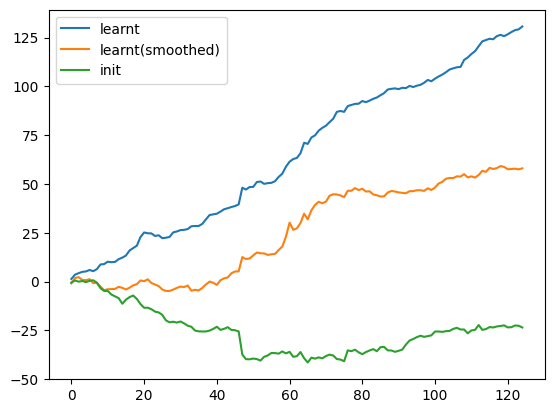

In [267]:
M = R[:min(R.shape[0],(flb+training_window_size)),inst_indices_to_train_on]
#M = R[:min(R.shape[0],(flb+training_window_size)),list(set(np.arange(R.shape[1])) - set(inst_indices_to_train_on))]
#M = R[:min(R.shape[0],(flb+training_window_size)), :]


####
def smoothen(v, nsize=1):
    r = np.full_like(v, 0.0)
    for i in range(len(v)):
        r[i] = np.mean(v[max(0,i-nsize):min(i+nsize,len(v))])
    return r

####
pred, resp = get_pred_resp(params, M, flb)
X = resp * pred
p1 = np.mean(X, axis=1)
a1 = ac1(pred)

####
pred, resp = get_pred_resp(init_params, M, flb)
X = resp * pred
p2 = np.mean(X, axis=1)
a2 = ac1(pred)

####
params2 = params.copy()
nf = len([_k for _k in params2.keys() if _k.startswith("beta_")])
for i in range(1, nf+1):
    b = params2['beta_'+str(i)]
    """***PARAMETER***"""
    w = 5
    b2 = smoothen(b, nsize=w)  ## design choice!
    #b2 = smoothen(b2, nsize=1)  ## design choice!
    params2['beta_'+str(i)] = b2 * (w)
pred, resp = get_pred_resp(params2, M, flb)
X = resp * pred
p3 = np.mean(X, axis=1)
a3 = ac1(pred)

####
sr = lambda v: np.sqrt(252) * np.mean(v) / np.std(v)
print("SR -> ", [sr(p1), sr(p2), sr(p3)])
print("acf -> ", [a1, a2, a3])
####
plt.plot(np.cumsum(p1), label="learnt")
plt.plot(np.cumsum(p3), label="learnt(smoothed)")
plt.plot(np.cumsum(p2), label="init")


plt.legend()
plt.show()

nf - 1
sr ->  [2.73585069 2.73585069]
corr_mat -> 
 [[1. 1.]
 [1. 1.]]


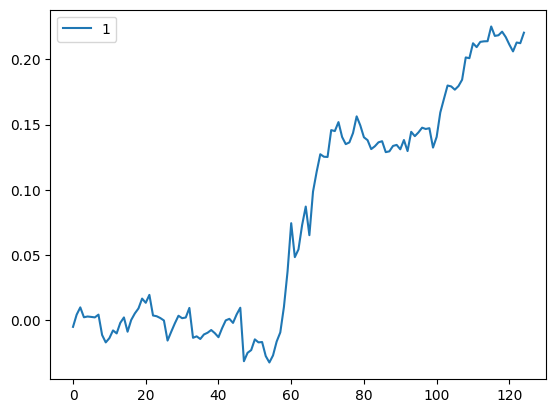

In [253]:
M = R[:min(R.shape[0],(flb+training_window_size)),inst_indices_to_train_on]
#M = R[:min(R.shape[0],(flb+training_window_size)),list(set(np.arange(R.shape[1])) - set(inst_indices_to_train_on))]
#M = R[:min(R.shape[0],(flb+training_window_size)), :]

#####################
pnl_per_beta = []
params2 = params.copy()
nf = len([_k for _k in params2.keys() if _k.startswith("beta_")])
print("nf -", nf)
for i in range(1, nf+1):
    b = params2['beta_'+str(i)]
    g = params2['gamma_'+str(i)]
    
    if True:
        w = 5
        b = smoothen(b, nsize=w)
        
    params_temp = {'beta_1' : b, 'gamma_1' : g}
    pred, resp = get_pred_resp(params_temp, M, flb)
    X = resp * _f(pred)
    p3 = np.mean(X, axis=1)
    pnl_per_beta.append(p3)
    
p = np.vstack(pnl_per_beta)
p_all = np.sum(p, axis=0)
p = np.vstack([p, p_all])
p_mean = np.mean(p, axis=1)
p_std  = np.std(p, axis=1)

sr = np.sqrt(252) * p_mean / p_std
print("sr -> ", sr)
print("corr_mat -> \n", np.corrcoef(p))


for i in range(nf):
    plt.plot(np.cumsum(p[i,:]),label=str(i+1))
    
plt.legend()
plt.show()

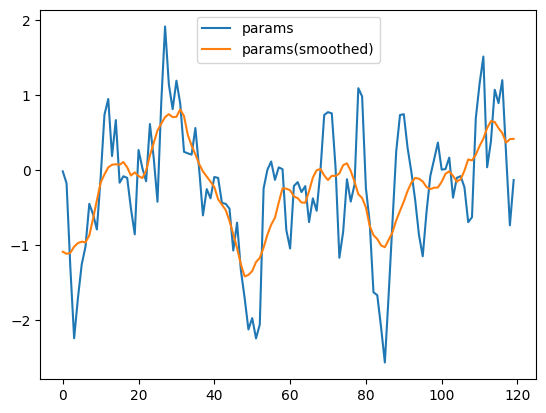

In [268]:
b = params['beta_1']
w = 5
b2 = smoothen(b, nsize=w)
#b3 = smoothen(b2, nsize=1)

plt.plot(b, label="params")
plt.plot(b2, label="params(smoothed)")
#plt.plot(b3, label="params(smoothed2)")

plt.legend()
plt.show()

In [ ]:
bi = init_params['beta_1']
b = params['beta_1']

plt.plot(bi, label="init params")
plt.plot(b, label="params")

print("corr(init, learnt) -> ", jnp.corrcoef(bi, b)[0, 1])

plt.legend()
plt.show()

In [ ]:
M = R[:min(R.shape[0],(flb+training_window_size)),inst_indices_to_train_on]
#M = R[:min(R.shape[0],(flb+training_window_size)),list(set(np.arange(R.shape[1])) - set(inst_indices_to_train_on))]
#M = R[:min(R.shape[0],(flb+training_window_size)), :]

####
pred, resp = get_pred_resp(params, M, flb)
X = resp * pred

_asym = lambda v: v + 1 * np.min(np.array([v, 0]))
X = np.vectorize(_asym)(X)

P = np.cumsum(X, axis=0)
plt.plot(P)

## Learning portfolio weights?

In [ ]:
M = R[:min(R.shape[0],(flb+training_window_size)),inst_indices_to_train_on]
#M = R[:min(R.shape[0],(flb+training_window_size)),list(set(np.arange(R.shape[1])) - set(inst_indices_to_train_on))]
#M = R[:min(R.shape[0],(flb+training_window_size)), :]

####
if False:
    pred, resp = get_pred_resp(params, M, flb)
else:
    params2 = params.copy()
    nf = len([_k for _k in params2.keys() if _k.startswith("beta_")])
    for i in range(1, nf+1):
        b = params2['beta_'+str(i)]
        """***PARAMETER***"""
        w = 5
        b2 = smoothen(b, nsize=w)  ## design choice!
        #b2 = smoothen(b2, nsize=1)  ## design choice!
        params2['beta_'+str(i)] = b2 * (w)
    pred, resp = get_pred_resp(params2, M, flb)

inst_idx = 10

p = pred[:, inst_idx]
r = resp[:, inst_idx]

def chain(w : np.ndarray, risk_aversion : float, p : jnp.ndarray, r : jnp.ndarray):
    """
        w is the parameters of our decison function which we need to learn.
        
        
        Useful resources
        ----------------
        
        1) [jax.lax module] https://jax.readthedocs.io/en/latest/jax.lax.html?highlight=jax.lax
        2) [jax.lax.scan] https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html#jax.lax.scan
        3) https://ericmjl.github.io/dl-workshop/02-jax-idioms/02-loopy-carry.html
        
    """
    
    ## state variables / variables going into the decision function
    pct_fails = 0
    cum_pnl = 0
    cum_max_draw = 0
    
    n_steps = 0
    
    ## 'wfunc' is our decision function.
    sigmoid = jit(lambda _a : 1. / (1 + jnp.exp(-_a)))
    #wfunc = jit(lambda pf, cp, cmd: 0.5 + sigmoid(jnp.dot(w, jnp.array([pf, cmd]))))
    wfunc = jit(lambda pf, cp, cmd: 0.5 + sigmoid(jnp.dot(w, jnp.array([cmd]))))
    #wfunc = jit(lambda pf, cp, cmd: 0.5 + sigmoid(jnp.dot(w, jnp.array([cp, cmd]))))
    
    #wfunc = jit(lambda pf, cp, cmd: 0.5 + sigmoid(jnp.dot(w, jnp.array([cp]))))

    def _scan_f(state, pr_i):
        pct_fails = state[0]
        cum_pnl   = state[1]
        cum_max_draw = state[2]
        n_steps   = state[3]
        max_cum_pnl = state[4]
        
        curr_weight = wfunc(pct_fails, cum_pnl, cum_max_draw)
        actual_pnl = curr_weight * pr_i
        risk_averse_pnl = jlax.cond(actual_pnl < 0, lambda _x: risk_aversion, lambda _x: 1., None) * actual_pnl
        
        n_fails = pct_fails*n_steps + jlax.cond(actual_pnl < 0., lambda _x: risk_aversion*1., lambda _x: 0., None)
        n_steps += jlax.cond(actual_pnl < 0, lambda _x: risk_aversion*1., lambda _x: 1., None)
        
        pct_fails = n_fails / n_steps
        
        cum_pnl += risk_averse_pnl
        max_cum_pnl = jlax.max(max_cum_pnl, cum_pnl)
        cum_max_draw = cum_pnl - max_cum_pnl
        
        return (pct_fails, cum_pnl, cum_max_draw, n_steps, max_cum_pnl), jnp.array([actual_pnl, curr_weight])
    
    init_state = (pct_fails, cum_pnl, cum_max_draw, n_steps, 0.0)
    carry, accumulated = jlax.scan(_scan_f, init_state, p*r)
    
    apnl = accumulated[:, 0]
    weights = accumulated[:, 1]
    
    return apnl, weights




@jit
def max_draw(v):
    """
        More negative the result, the greater the max drawdown.
    """
    return jnp.min(jnp.cumsum(v) - jnp.max(jnp.cumsum(v)))

def obj_func_helper(params, pred : np.ndarray, resp : np.ndarray):
    
    w = params['w']
    risk_aversion = 1. #params["risk_aversion"]
        
    _sr = lambda v : jnp.sqrt(252) * jnp.mean(v) / jnp.std(v)
    _sortino = lambda v: jnp.sqrt(252) * jnp.mean(v) / jnp.sqrt(  jnp.sum(vmap(lambda x: jlax.cond(x < 0., lambda _x: jlax.pow(_x, 2.), lambda _x: 0., x), in_axes=0) (v))  / jnp.sum(vmap(lambda x: jlax.cond(x < 0., lambda _x: 1., lambda _x: 0., None), in_axes=0) (v)))
    def _h(p, r):
        apnl, _ = chain(w=w, risk_aversion=risk_aversion, p=p, r=r)
        #return _sr(apnl)
        return _sortino(apnl)
    #_sr2 = lambda v1, v2: _sr(v1*v2)
    _sr2 = lambda v1, v2: _sortino(v1*v2)
    
    D = jnp.array([tuple([pred[:, i], resp[:, i]]) for i in range(pred.shape[1])])
    sr_xc = vmap(lambda arg: _h(*arg), in_axes=0)(D)
    sr_x = vmap(lambda arg: _sr2(*arg), in_axes=0)(D)
    sr_delta = sr_xc - sr_x
    
    
    #obj = jnp.median(sr_delta)
    #obj = jnp.median(sr_delta) / jnp.median( jnp.abs( sr_delta - jnp.median(sr_delta) ) )
    #obj = jnp.percentile(sr_delta, 5)
    #obj = (jnp.percentile(sr_delta, 95) - jnp.percentile(sr_delta, 5))
    #obj = jnp.max(sr_delta)
    #obj = jnp.percentile(sr_delta, 75)
    obj = jnp.min(sr_delta)
    
    
    return obj, sr_delta


def loss(params, pred: np.ndarray, resp: np.ndarray):
    obj, _ = obj_func_helper(params=params, pred=pred, resp=resp)
    return -1 * obj
    


def fit(params: optax.Params, optimizer: optax.GradientTransformation, pred : np.ndarray, resp: np.ndarray, max_iter : int) -> optax.Params:
    opt_state = optimizer.init(params)

    @jit
    def step(params, opt_state):
        loss_value, grads = value_and_grad(loss)(params, pred, resp)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value
    
    for i in range(max_iter):
        params, opt_state, loss_value = step(params, opt_state)
        if np.isnan(loss_value):
            return params
        if i % int(max_iter/10) == 0:
            print(f'step {i}, loss: {loss_value}')

    return params


def train(init_params, pred, resp, adam_learning_rate=1e-4, max_iter=100000):
    optimizer = optax.adam(learning_rate=adam_learning_rate)
    #optimizer = optax.rmsprop(learning_rate=adam_learning_rate)
    params = fit(init_params, optimizer, pred, resp, max_iter)
    return params







x = p * r
#w = np.array([-10.,  -2.])
w = np.array([  -.5])
#w = np.array([0.02])




if True:
    
    #init_params = {'w' : w, "risk_aversion" : .5}
    init_params = {'w' : w}
    print(init_params)
    
    learnt_params = train(init_params, pred, resp, adam_learning_rate=1e-3, max_iter=50000)
    print(learnt_params)
        
    print('Done.')
    
if False:
    b4 = time.time()
    
    init_params = {'w' : w}
    
    sr_delta = obj_func_helper(init_params, pred, resp)
    after = time.time()
    print(after-b4)

    plt.hist(sr_delta, label="$sr_{xc} - sr_{x}$")
    print("mean(sr_delta) -> ", jnp.mean(sr_delta))
    print("q25(sr_delta) -> ", jnp.percentile(sr_delta, 25)) ## onjective function: maximize q25
    print("min(sr_delta) -> ", jnp.min(sr_delta)) ## onjective function: maximize min
    
    
    plt.legend()
    plt.show()


In [ ]:
plt.plot(weights)
print(np.corrcoef(weights[:-1], weights[1:])[0, 1])

In [ ]:
_, sr_delta = obj_func_helper(learnt_params, pred, resp)
after = time.time()
print(after-b4)

plt.hist(sr_delta, label="$sr_{xc} - sr_{x}$")
print("mean(sr_delta) -> ", jnp.mean(sr_delta))
print("q25(sr_delta) -> ", jnp.percentile(sr_delta, 20)) ## onjective function: maximize q25
print("min(sr_delta) -> ", jnp.min(sr_delta)) ## onjective function: maximize min

In [ ]:
w2 = learnt_params['w']
risk_aversion2 = 1. #learnt_params["risk_aversion"]

def _h(p, r):
    apnl, _ = chain(w=w2, risk_aversion=risk_aversion2, p=p, r=r)
    return apnl
D = jnp.array([tuple([pred[:, i], resp[:, i]]) for i in range(pred.shape[1])])
A = vmap(lambda arg: _h(*arg), in_axes=0)(D)
A = A.transpose()

new_pnl = np.sum(A, axis=1)
old_pnl = np.sum(pred * resp, axis=1)

new_pnl = new_pnl * np.std(old_pnl) / np.std(new_pnl)

_sr = lambda v : jnp.sqrt(252) * jnp.mean(v) / jnp.std(v)
_sortino = lambda v: jnp.sqrt(252) * jnp.mean(v) / jnp.sqrt(  jnp.sum(vmap(lambda x: jlax.cond(x < 0., lambda _x: jlax.pow(_x, 2.), lambda _x: 0., x), in_axes=0) (v))  / jnp.sum(vmap(lambda x: jlax.cond(x < 0., lambda _x: 1., lambda _x: 0., None), in_axes=0) (v)))
print(jnp.std(old_pnl), jnp.std(new_pnl))
print([_sr(old_pnl), _sr(new_pnl), _sr(new_pnl) - _sr(old_pnl)])
print([_sortino(old_pnl), _sortino(new_pnl), _sortino(new_pnl) - _sortino(old_pnl)])

plt.plot(np.cumsum(new_pnl), label="new")
plt.plot(np.cumsum(old_pnl), label="old")

plt.legend()
plt.show()

In [ ]:
M = R[:min(R.shape[0],(flb+training_window_size)),inst_indices_to_train_on]
M = R[:min(R.shape[0],(flb+training_window_size)),list(set(np.arange(R.shape[1])) - set(inst_indices_to_train_on))]
#M = R[:min(R.shape[0],(flb+training_window_size)), :]

if False:
    pred, resp = get_pred_resp(params, M, flb)
else:
    params2 = params.copy()
    nf = len([_k for _k in params2.keys() if _k.startswith("beta_")])
    for i in range(1, nf+1):
        b = params2['beta_'+str(i)]
        """***PARAMETER***"""
        w = 2
        b2 = smoothen(b, nsize=w)  ## design choice!
        #b2 = smoothen(b2, nsize=1)  ## design choice!
        params2['beta_'+str(i)] = b2 * (w)
    pred, resp = get_pred_resp(params2, M, flb)
    

w2 = learnt_params['w']
risk_aversion2 = 1. #learnt_params["risk_aversion"]

def _h(p, r):
    apnl, _ = chain(w=w2, risk_aversion=risk_aversion2, p=p, r=r)
    return apnl
D = jnp.array([tuple([pred[:, i], resp[:, i]]) for i in range(pred.shape[1])])
A = vmap(lambda arg: _h(*arg), in_axes=0)(D)
A = A.transpose()

new_pnl = np.sum(A, axis=1)
old_pnl = np.sum(pred * resp, axis=1)

new_pnl = new_pnl * np.std(old_pnl) / np.std(new_pnl)

_sr = lambda v : jnp.sqrt(252) * jnp.mean(v) / jnp.std(v)
_sortino = lambda v: jnp.sqrt(252) * jnp.mean(v) / jnp.sqrt(  jnp.sum(vmap(lambda x: jlax.cond(x < 0., lambda _x: jlax.pow(_x, 2.), lambda _x: 0., x), in_axes=0) (v))  / jnp.sum(vmap(lambda x: jlax.cond(x < 0., lambda _x: 1., lambda _x: 0., None), in_axes=0) (v)))
print(jnp.std(old_pnl), jnp.std(new_pnl))
print([_sr(old_pnl), _sr(new_pnl), _sr(new_pnl) - _sr(old_pnl)])
print([_sortino(old_pnl), _sortino(new_pnl), _sortino(new_pnl) - _sortino(old_pnl)])

plt.plot(np.cumsum(new_pnl), label="new")
plt.plot(np.cumsum(old_pnl), label="old")

plt.legend()
plt.show()

## Kernel based Time series feature engineering

In [ ]:
_del = 1e-3
_c = 0.01

f1 = jit(lambda z: 1 / (1+jlax.exp(-5*(z-1))))
f2 = jit(lambda z: 1 -1 / (1+jlax.exp(-5*(z+1))))
f12 = jit(lambda z: (z**2)*(f1(z)+f2(z)) )

@jit
def l2_norm(v):
    return jnp.sqrt(jnp.dot(v, v))

@jit
def zero_mean_constraint(v):
    arg = jnp.sum(v)
    arg /= _del
    return _c*f12(arg)
    
@jit
def orthogonality_constraint(v1, v2):
    arg = jnp.dot(v1, v2) / (l2_norm(v1) * l2_norm(v2))
    arg /= _del
    return _c * f12(arg)


@jit
def unit_norm_constraint(v):
    arg = jnp.dot(v, v) - 1
    arg /= _del
    return _c * f12(arg)

@jit
def project(v_to_project, v_to_project_on):
    return jnp.dot(v_to_project, v_to_project_on) / jnp.dot(v_to_project_on, v_to_project_on)

@jit
def rowwise_csz(M):
    ## cross-sectionally z-score
    mean = jnp.mean(M, axis=1)
    sd = jnp.std(M, axis=1)
    return (M - mean[:, None]) / sd[:, None]


g1 = jit(lambda z, e: 1 / (1+jlax.exp(-50*(z-e))))
g2 = jit(lambda z, e: 1 -1 / (1+jlax.exp(-50*(z+e))))
g12 = jit(lambda z, e: (g1(z,e)+g2(z,e)) )

@jit
def shapelet(x : jnp.ndarray, loc, width, offset, coeff, L):
    return coeff * ( g12(x/L + loc/L, e=width)*L + offset )

@jit
def shapelet_call(x : jnp.ndarray, sdef, L):
    return shapelet(x, -1*jnp.sqrt((sdef['loc']*sdef['loc'])), sdef['width'], sdef['offset'], sdef['coeff'], L)



from scipy.special import legendre
@jit
def eval_p(val : float, _p : np.ndarray):
    s = 0
    for i in range(_p.shape[0]):
        s += _p[i] * pow(val, _p.shape[0]-i)
    return s

def get_legendre_kernel(lp_degree, support):
    p = legendre(lp_degree).coeffs
    return vmap(lambda arg: eval_p(arg, p), in_axes=0)(support)


def initialize_params(feature_lb, n_factors):
    ## Set the seed.
    np.random.seed(0)
    init_params = dict(zip(\
                           ["weight_%s" % str(i) for i in range(1, n_factors+1)],\
                           [0.1 for i in range(1, n_factors+1)]\
                          ))
    return init_params

def get_pred_resp(params, R, flb):
    """
        
        R   -> TxN matrix (T: timestamps, N:number of instruments)
               T > flb
        flb -> feature definition lookback
    """
    
    #assert(R.shape[0] > flb)
    
    n_ts = R.shape[0]
    n_inst = R.shape[1]
    
    ## n new feature definitions to learn.
    n_factors = len(params.keys())
    
    R_rolling = np.lib.stride_tricks.sliding_window_view(R, window_shape=flb, axis=0).transpose(0, 2, 1)
    
    R_train = R_rolling[:-1, :, :]
    R_target = R_rolling[1:, -1, :]
    
    block_fcst = jnp.full_like(R_target, 0.0)
    support = 2*jnp.arange(flb) / flb - 1.0
    for f_idx in range(1, n_factors+1):
        beta = get_legendre_kernel(f_idx-1, support)
        gamma = params["weight_"+str(f_idx)]
        f_idx_fcst = (vmap(lambda X: jnp.dot(beta, X), in_axes=0)) (R_train)
        f_idx_fcst *= gamma
        #assert( f_idx_fcst.shape[1] == n_inst )
        block_fcst += f_idx_fcst
    
    if False:
        ## cross-sectionally z-score
        block_fcst = rowwise_csz(block_fcst)
        
    return block_fcst, R_target


def objective(params, R, flb):
    """
        
        R   -> TxN matrix (T: timestamps, N:number of instruments)
               T > flb
        flb -> feature definition lookback
    """
    
    #assert(R.shape[0] > flb)
        
    ## n new feature definitions to learn.
    n_factors = len(params.keys())
    
    block_fcst, R_target = get_pred_resp(params, R, flb)
    
    ## normalize each row - 
    foo = vmap(lambda v: l2_norm(v), in_axes=0)
    
    n = foo(R_target)
    R_target /= n[:, None]

    n = foo(block_fcst)
    block_fcst /= n[:, None]
    
    X = R_target * block_fcst
    obj = jnp.mean(jnp.sum(X, axis=1))
    
    """
        No penalties as we are using orthogonal functional basis.
    """
    return obj


def loss(params, R, flb):
    return -1 * objective(params, R, flb)


def fit(params: optax.Params, optimizer: optax.GradientTransformation, R : np.ndarray, flb : int, max_iter : int) -> optax.Params:
    opt_state = optimizer.init(params)

    @jit
    def step(params, opt_state):
        loss_value, grads = value_and_grad(loss)(params, R, flb)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value
    
    for i in range(max_iter):
        params, opt_state, loss_value = step(params, opt_state)
        if np.isnan(loss_value):
            return params
        if i % int(max_iter/10) == 0:
            print(f'step {i}, loss: {loss_value}')

    return params


def train(init_params, R, flb, adam_learning_rate=1e-4, max_iter=100000):
    optimizer = optax.adam(learning_rate=adam_learning_rate)
    #optimizer = optax.rmsprop(learning_rate=adam_learning_rate)
    params = fit(init_params, optimizer, R, flb, max_iter)
    return params



flb = 120
n_factors = 10
init_params = initialize_params(flb, n_factors)
#objective(init_params, R, flb)
#%timeit objective(init_params, R, flb)


b4 = time.time()
params = train(init_params, R[:, :50], flb, adam_learning_rate=1e-3, max_iter=10000)
after = time.time()
print(after-b4)


In [ ]:
params

In [ ]:
raw_support = jnp.arange(flb)
support = 2*raw_support / flb - 1.0
b_sum = np.full_like(support, 0.0)
for f_idx in range(1, n_factors+1):
    beta = get_legendre_kernel(f_idx-1, support)
    gamma = params["weight_"+str(i)]
    b_sum += (gamma * beta)
    #plt.plot(raw_support, beta*gamma, label=str(f_idx-1))

plt.plot(raw_support, b_sum, label="all")

plt.legend()
plt.show()

In [ ]:
M = R[:, :50]
M = R[:, 50:]
#M = R

####
pred, resp = get_pred_resp(params, M, flb)
X = resp * pred
p1 = np.mean(X, axis=1)

####
pred, resp = get_pred_resp(init_params, M, flb)
X = resp * pred
p2 = np.mean(X, axis=1)

####
sr = lambda v: np.sqrt(252) * np.mean(v) / np.std(v)
print([sr(p1), sr(p2)])

####
plt.plot(np.cumsum(p1), label="learnt")
plt.plot(np.cumsum(p2), label="init")

plt.legend()
plt.show()